In [1]:
# 安装结巴分词
# pip install jieba
import jieba 
import pandas as pd 
import numpy as np 
from tensorflow.keras.layers import Dense, Input, Dropout
from tensorflow.keras.layers import Conv2D, GlobalMaxPool2D, Embedding, concatenate
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
import tensorflow.keras.backend as K
from sklearn.model_selection import train_test_split
import json
# pip install plot_model
from plot_model import plot_model

D:\Anaconda3\lib\site-packages\numpy\_distributor_init.py:32: UserWarning: loaded more than 1 DLL from .libs:
D:\Anaconda3\lib\site-packages\numpy\.libs\libopenblas.IPBC74C7KURV7CB2PKT5Z5FNR3SIBV4J.gfortran-win_amd64.dll
D:\Anaconda3\lib\site-packages\numpy\.libs\libopenblas.PYQHXLVVQ7VESDPUVUADXEVJOBGHJPAY.gfortran-win_amd64.dll
  stacklevel=1)


In [2]:
# 批次大小
batch_size = 128
# 训练周期
epochs = 3
# 词向量长度
embedding_dims = 128
# 滤波器数量
filters = 32

In [3]:
# 这个数据前半部分都是正样本，后半部分都是负样本
data = pd.read_csv('weibo_senti_100k.csv')
# 查看数据前5行
data.head()

,label,review
0,1,﻿更博了，爆照了，帅的呀，就是越来越爱你！生快傻缺[爱你][爱你][爱你]
1,1,@张晓鹏jonathan 土耳其的事要认真对待[哈哈]，否则直接开除。@丁丁看世界 很是细心...
2,1,姑娘都羡慕你呢…还有招财猫高兴……//@爱在蔓延-JC:[哈哈]小学徒一枚，等着明天见您呢/...
3,1,美~~~~~[爱你]
4,1,梦想有多大，舞台就有多大![鼓掌]


In [4]:
# 计算正样本数量
poslen = sum(data['label']==1)
# 计算负样本数量
neglen = sum(data['label']==0)
print('正样本数量：', poslen)
print('负样本数量：', neglen)

正样本数量： 59993
负样本数量： 59995


In [5]:
# 测试一下结巴分词的使用
print(list(jieba.cut('做父母一定要有刘墉这样的心态，不断地学习，不断地进步')))

Building prefix dict from the default dictionary ...
I0423 10:07:49.042580 11316 __init__.py:113] Building prefix dict from the default dictionary ...
Dumping model to file cache C:\Users\qbf\AppData\Local\Temp\jieba.cache
I0423 10:07:49.617033 11316 __init__.py:147] Dumping model to file cache C:\Users\qbf\AppData\Local\Temp\jieba.cache
Loading model cost 0.637 seconds.
I0423 10:07:49.681860 11316 __init__.py:165] Loading model cost 0.637 seconds.
Prefix dict has been built successfully.
I0423 10:07:49.682858 11316 __init__.py:166] Prefix dict has been built successfully.


['做', '父母', '一定', '要', '有', '刘墉', '这样', '的', '心态', '，', '不断', '地', '学习', '，', '不断', '地', '进步']


In [6]:
#定义分词函数，对传入的x进行分词
cw = lambda x: list(jieba.cut(x))
# apply传入一个函数，把cw函数应用到data['review']的每一行
# 把分词后的结果保存到data['words']中
data['words'] = data['review'].apply(cw)

In [7]:
# 再查看数据前5行
data.head()

,label,review,words
0,1,﻿更博了，爆照了，帅的呀，就是越来越爱你！生快傻缺[爱你][爱你][爱你],"[﻿, 更博, 了, ，, 爆照, 了, ，, 帅, 的, 呀, ，, 就是, 越来越, 爱..."
1,1,@张晓鹏jonathan 土耳其的事要认真对待[哈哈]，否则直接开除。@丁丁看世界 很是细心...,"[@, 张晓鹏, jonathan, , 土耳其, 的, 事要, 认真对待, [, 哈哈,..."
2,1,姑娘都羡慕你呢…还有招财猫高兴……//@爱在蔓延-JC:[哈哈]小学徒一枚，等着明天见您呢/...,"[姑娘, 都, 羡慕, 你, 呢, …, 还有, 招财猫, 高兴, …, …, /, /, ..."
3,1,美~~~~~[爱你],"[美, ~, ~, ~, ~, ~, [, 爱, 你, ]]"
4,1,梦想有多大，舞台就有多大![鼓掌],"[梦想, 有, 多, 大, ，, 舞台, 就, 有, 多, 大, !, [, 鼓掌, ]]"


In [8]:
# 计算一条数据最多有多少个词汇
max_length = max([len(x) for x in data['words']])
# 打印看到结果为202，最长的句子词汇数不算太多
# 后面就以202作为标准，把所有句子的长度都填充到202的长度
# 比如最长的句子为2000，那么说明有些句子太长了，我们可以设置一个小一点的值作为所有句子的标准长度
# 比如设置1000，那么超过1000的句子只取前面1000个词，不足1000的句子填充到1000的长度
print(max_length)

202


In [9]:
# 把data['words']中所有的list都变成字符串格式
texts = [' '.join(x) for x in data['words']]

In [10]:
# 查看一条评论，现在数据变成了字符串格式，并且词与词之间用空格隔开
# 这是为了满足下面数据处理对格式的要求，下面要使用Tokenizer对数据进行处理
texts[4]

'梦想 有 多 大 ， 舞台 就 有 多 大 ! [ 鼓掌 ]'

In [11]:
# 实例化Tokenizer，设置字典中最大词汇数为30000
# Tokenizer会自动过滤掉一些符号比如：!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n
tokenizer = Tokenizer(num_words=30000)
# 传入我们的训练数据，建立词典，词的编号根据词频设定，频率越大，编号越小，
tokenizer.fit_on_texts(texts) 
# 把词转换为编号，编号大于30000的词会被过滤掉
sequences = tokenizer.texts_to_sequences(texts) 
# 把序列设定为max_length的长度，超过max_length的部分舍弃，不到max_length则补0
# padding='pre'在句子前面进行填充，padding='post'在句子后面进行填充
X = pad_sequences(sequences, maxlen=max_length, padding='pre')  
# X = np.array(sequences)

In [12]:
# 获取字典
dict_text = tokenizer.word_index
# 在字典中查询词dui yi
dict_text['梦想']

581

In [13]:
# 把token_config保存到json文件中，模型预测阶段可以使用
file = open('token_config.json','w',encoding='utf-8')
# 把tokenizer变成json数据
token_config = tokenizer.to_json()
# 保存json数据
json.dump(token_config, file)

In [19]:
print(X[4])

[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0  581   18   75   77    1
 1946 

In [15]:
# 定义标签
# 01为正样本，10为负样本
positive_labels = [[0, 1] for _ in range(poslen)]
negative_labels = [[1, 0] for _ in range(neglen)]
# 合并标签
Y = np.array(positive_labels + negative_labels)
# 切分数据集
x_train,x_test,y_train,y_test = train_test_split(X, Y, test_size=0.2)

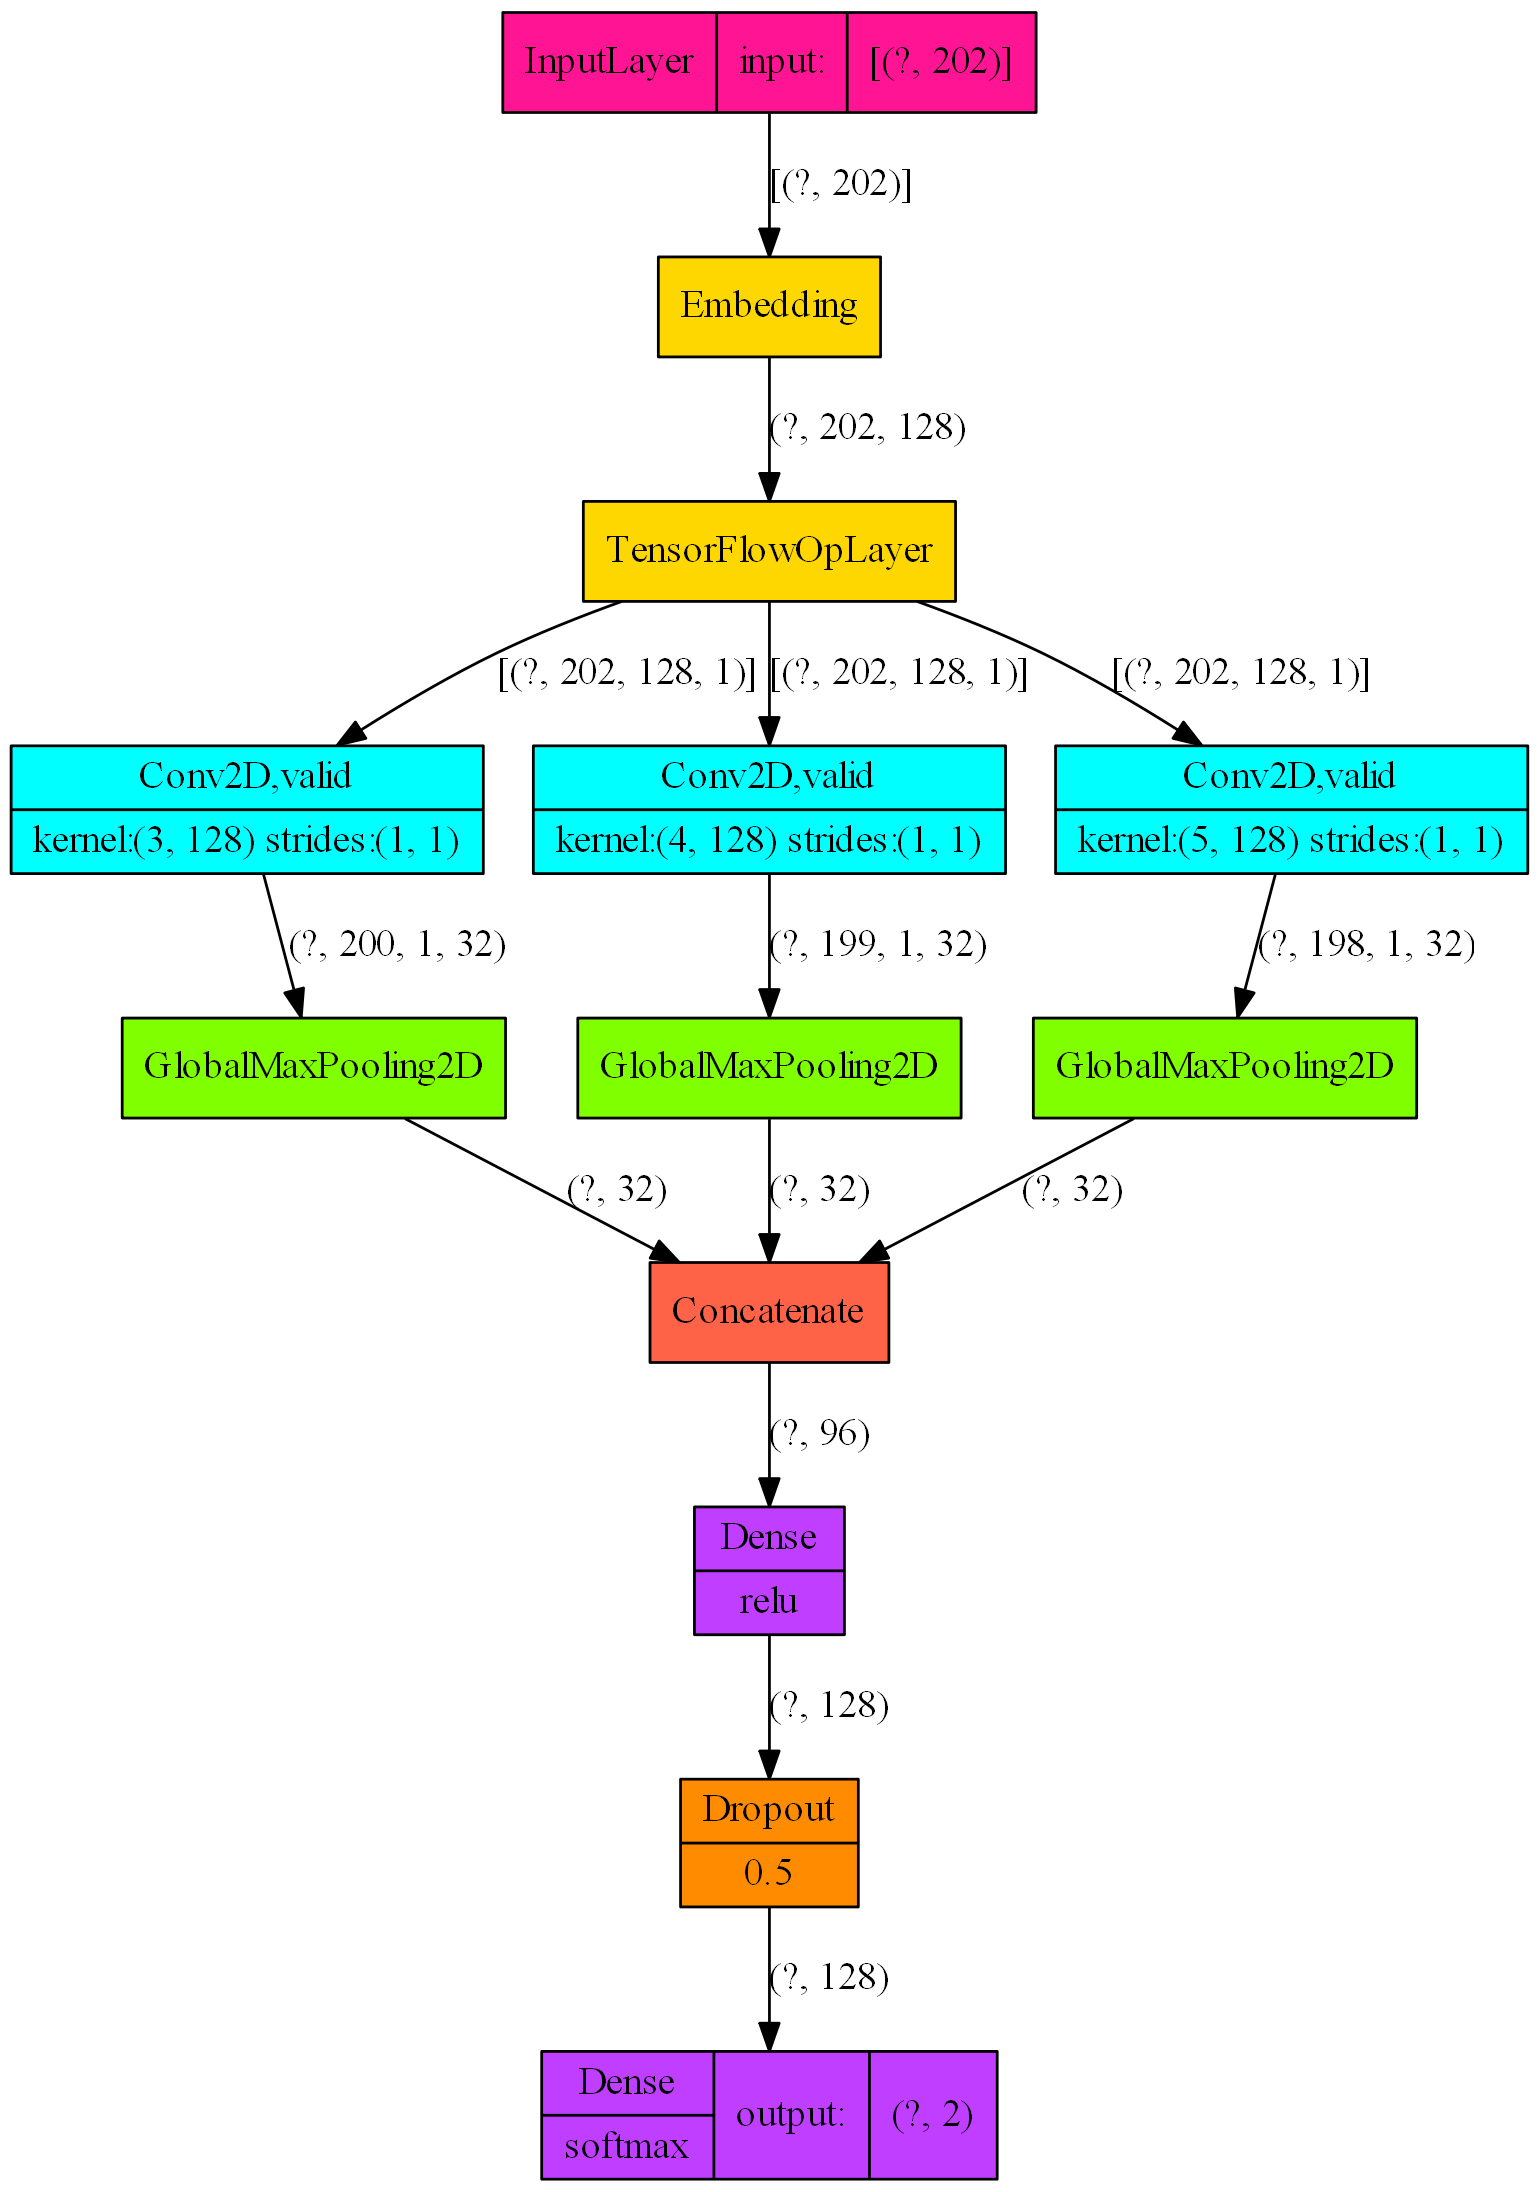

In [20]:
# 定义函数式模型
# 定义模型输入，shape-(batch, 202)
sequence_input = Input(shape=(max_length,))
# Embedding层，30000表示30000个词，每个词对应的向量为128维
embedding_layer = Embedding(input_dim=30000, output_dim=embedding_dims)
# embedded_sequences的shape-(batch, 202, 128)
embedded_sequences = embedding_layer(sequence_input)
# embedded_sequences的shape变成了(batch, 202, 128, 1)
embedded_sequences = K.expand_dims(embedded_sequences, axis=-1)

# 卷积核大小为3,列数必须等于词向量长度
cnn1 = Conv2D(filters=filters, kernel_size=(3,embedding_dims), activation='relu')(embedded_sequences)
cnn1 = GlobalMaxPool2D()(cnn1)

# 卷积核大小为4,列数必须等于词向量长度
cnn2 = Conv2D(filters=filters, kernel_size=(4,embedding_dims), activation='relu')(embedded_sequences)
cnn2 = GlobalMaxPool2D()(cnn2)

# 卷积核大小为5,列数必须等于词向量长度
cnn3 = Conv2D(filters=filters, kernel_size=(5,embedding_dims), activation='relu')(embedded_sequences)
cnn3 = GlobalMaxPool2D()(cnn3)

# 合并
merge = concatenate([cnn1, cnn2, cnn3], axis=-1)
# 全链接层
x = Dense(128, activation='relu')(merge)
# Dropout层
x = Dropout(0.5)(x)
# 输出层
preds = Dense(2, activation='softmax')(x)
# 定义模型
model = Model(sequence_input, preds)

plot_model(model, dpi=200)

In [17]:
# 定义代价函数，优化器
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['acc'])

# 训练模型
model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          validation_data=(x_test, y_test))

Train on 95990 samples, validate on 23998 samples
Epoch 1/3
95990/95990 [==============================] - 30s 318us/sample - loss: 0.0765 - acc: 0.9705 - val_loss: 0.0434 - val_acc: 0.9814
Epoch 2/3
95990/95990 [==============================] - 27s 282us/sample - loss: 0.0415 - acc: 0.9821 - val_loss: 0.0528 - val_acc: 0.9815
Epoch 3/3
95990/95990 [==============================] - 27s 282us/sample - loss: 0.0346 - acc: 0.9832 - val_loss: 0.0720 - val_acc: 0.9793


In [18]:
# 保存模型
model.save('cnn_model.h5') 